# Introduzione alle Reti Neurali

# Reti MLP
Il termine *Multi-layer Perceptron* può confondere un pò perchè i neuroni artificiali (*unità*) di queste reti sono in genere funzioni logistiche, non percettroni. Possiamo intendere i neuroni di una rete MLP come neuroni logistici che restituiscono valori nel range continuo 0-1.

## Esempio giocattolo (di classificazione)

In [1]:
# l'import dei package necessari:

import numpy as np
import pandas as pd

from pathlib import Path                               # per la gestione dei path-name del file system

from sklearn.neural_network import MLPClassifier       # il classificatore a rete neurale MLP

from sklearn.model_selection import train_test_split   # per lo split tra dati di train e di test

from sklearn.preprocessing import StandardScaler       # per la standardizzazione dei dati 

from sklearn.pipeline import Pipeline                  # per costruire una pipeline di trasformazioni con uno stimatore 
                                                       # finale

from sklearn.metrics import make_scorer                # per calcolare lo score da una metrica di prestazione o da una 
                                                       # loss function
    
from sklearn.metrics import accuracy_score             # accuracy classification score

from sklearn.model_selection import GridSearchCV       # la GridSearchCV

import dmba                                            # package di utility (prima fare 'pip install dmba' da un prompt
                                                       # anaconda, se non ancora fatto)
from dmba import classificationSummary                 # per la matrice di confusione

import matplotlib.pyplot as plt                        # per i grafici matplotlib
%matplotlib inline  
                                                       # per una buona visualizzazione di grafici matplotlib in 
                                                       # celle (vedi il post stackoverflow 43027980)

from IPython.display import Image                      # per importare in una cella CODICE un'immagine (PML)

In [15]:
# caricamento del dataset dal pacchetto dmba (non dalla directory locale!)
example_df = dmba.load_data('TinyData.csv') 
example_df.head(10)

,Obs.,Fat,Salt,Acceptance
0,1,0.2,0.9,like
1,2,0.1,0.1,dislike
2,3,0.2,0.4,dislike
3,4,0.2,0.5,dislike
4,5,0.4,0.5,like
5,6,0.3,0.8,like


In [16]:
example_df.shape # le dimensioni (un dataset minuscolo)

(6, 4)

In [17]:
# preparazione dei metadati e dati:
predictors = ['Fat', 'Salt']
outcome = 'Acceptance'

X = example_df[predictors]
y = example_df[outcome]
classes = sorted(y.unique())   # 'y.unique()' --> array(['dislike (0)', 'like(1)']

In [22]:
print(X)
print()
print(y)
print()
print(classes)

   Fat  Salt
0  0.2   0.9
1  0.1   0.1
2  0.2   0.4
3  0.2   0.5
4  0.4   0.5
5  0.3   0.8

0       like
1    dislike
2    dislike
3    dislike
4       like
5       like
Name: Acceptance, dtype: object

['dislike', 'like']


In [23]:
# la costruzione dell'oggetto di classe 'MLPClassifier' (scikit-learn) con un modello 2-3-1:
clf = MLPClassifier(hidden_layer_sizes=(3), activation='logistic', solver='lbfgs', random_state=1,verbose=3)

                               # 3 nodi in un unico livello nascosto; hidden_layer_sizes=(3) = hidden_layer_sizes=(3,);
                               # dall'help: "the i-th element represents the number of neurons in the i-th hidden layer
        
                               # la funzione logistica (sigmoidale);
    
                               # LBGFS è un metodo quasi-Newton, adatto per piccoli dataset; converge più velocemente di
                               # 'adam', che è una famosa, importante e molto utilizzata nuova variante della discesa del 
                               # gradiente, adatta per dataset più grandi (almeno di migliaia di righe di training);
                               
                               # 'random_state' per la riproducibilità, considerati infatti i seguenti aspetti pseudo-casuali:
                               #  - l'inizializzazione di pesi e bias;
                               #  - lo split train-test se si usa early stopping;
                               #  - il campionamento del batch se si usa un algoritmo 'sgd’ o ‘adam’;
                               #  - il rimescolamento del training set ad ogni inizio epoca (vedi più avanti).
                             
                               # --> notare il numero e la complessità logica dei parametri di 'MLPClassifier'
                            
                               # una nota sull'argomento "shuffle": il ri-mescolamento del training set ad inizio di ogni 
                               # epoca può essere utile per evitare che l'algoritmo si blocchi in qualche loop.
                               # secondo Goodfellow / Bengio, comunque, è importante farlo almeno una volta (p. 273).
                            
# Dall'help in linea: "This model optimizes the log-loss function (cioè, la negative log-likelihood) using LBFGS or 
# stochastic gradient descent".

In [24]:
type(clf)

sklearn.neural_network._multilayer_perceptron.MLPClassifier

Alcuni utili link:<br><br>
[la documentazione scikit-learn di MLPClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html)<br>
[il metodo L-BFGS](https://en.wikipedia.org/wiki/Limited-memory_BFGS)<br>
[il metodo Adam](https://en.wikipedia.org/wiki/Stochastic_gradient_descent#Adam)<br>
[perchè *MLPClassifier* non supporta la funzione *softmax*?](https://stats.stackexchange.com/questions/243588/how-to-apply-softmax-as-activation-function-in-multi-layer-perceptron-in-scikit)

Gli **iperparametri** sono gli argomenti di una classe (stimatore) da ottimizzare, in genere tramite la Cross-Validation oppure per *prova ed errore* manuale.<br>
Gli iper-parametri di *MLPClassifier* sono:
* il numero di layer/nodi nascosti (argomento *hidden_layer_sizes*);
* il learning rate eta (argomento *learning rate*) se si usa SGD;
* il numero di epoche (argomento *max_iter*).

Non confondere questi iper-parametri con i veri parametri, cioè i pesi ed i bias, da stimare in base ai dati di training.

In [25]:
clf.get_params()               # restituisce i parametri (gli argomenti!!) dello stimatore [default e nostre scelte];
                               # non tutti hanno significato nel nostro contesto, ad esempio il learning rate è utilizzato dai
                               # metodi della discesa del gradiente, non da quelli quasi-Newton (come appunto 'lbfgs').

{'activation': 'logistic',
 'alpha': 0.0001,
 'batch_size': 'auto',
 'beta_1': 0.9,
 'beta_2': 0.999,
 'early_stopping': False,
 'epsilon': 1e-08,
 'hidden_layer_sizes': 3,
 'learning_rate': 'constant',
 'learning_rate_init': 0.001,
 'max_fun': 15000,
 'max_iter': 200,
 'momentum': 0.9,
 'n_iter_no_change': 10,
 'nesterovs_momentum': True,
 'power_t': 0.5,
 'random_state': 1,
 'shuffle': True,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 3,
 'warm_start': False}

In [27]:
# il fit del modello ai dati (qui dentro c'è l'algoritmo iterativo):
clf.fit(X, y)                  # Fits the model to data matrix X and target(s) y.

                               # cioè, in questo caso, trovare il Decision Boundary (una curva perchè p=2, altrimenti una
                               # surface se p>2) che minimizza il numero di mis-classificazioni.

                               # gli argomenti documentati dall'help on-line sono solo quelli specifici di questo metodo.
                               # l'elenco degli iper-parametri è riportato solo dall'help on-line del metodo costruttore.
                
                               # Returns a trained MLP model.
                    
                               # E' questo il metodo più lento, quello che fa il vero lavoro. L'algoritmo iterativo è qui.

MLPClassifier(activation='logistic', hidden_layer_sizes=3, random_state=1,
              solver='lbfgs', verbose=3)

Per comodità riportiamo qui sotto il nostro modello di rete:

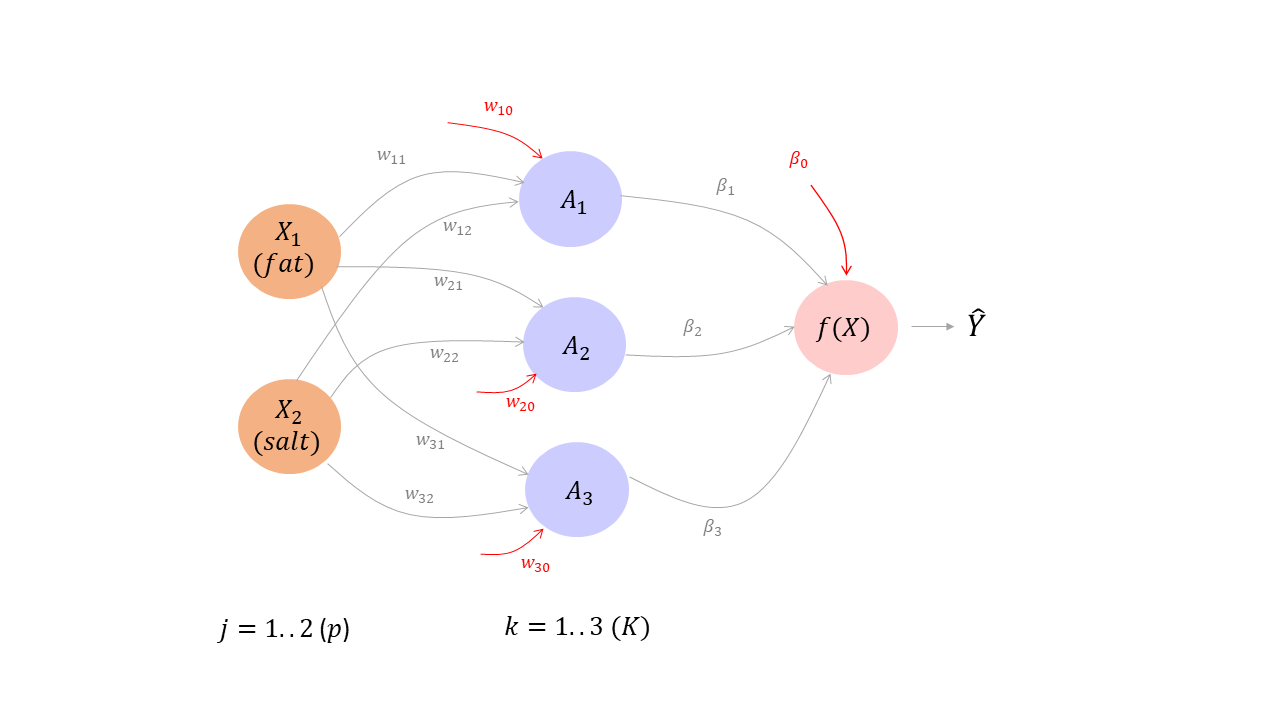

In [28]:
Image(filename='./images/Rete_giocattolo_python.png', width=1000) 

In [29]:
clf.intercepts_              # le 4 intercette (BIAS) del nostro modello 2-3-1; 
                             # - tre per il livello nascosto, una per ogni net input (w10, w20, e w30);
                             # - la quarta (beta0) per il livello di output (unico nodo).

[array([0.13368045, 4.07247552, 7.00768104]), array([14.30748676])]

In [31]:
clf.coefs_      # i pesi (WEIGHT) del nostro modello 2-3-1:
                # - prima sono elencati i 6 w-jk tra livello di input e livello nascosto, cioè: w11, w12, e w13 
                #   come prima riga dell'array (relativa alle uscite di X1); poi w21, w22, e w23 sulla seconda  
                #   riga dell'array (relativa alle uscite di X2);
                # - poi sono elencati i 3 beta-m (con m=1..3) tra il livello nascosto e quello di output

[array([[ -1.30656481,  -4.20427792, -13.29587332],
        [ -0.04399727,  -4.91606924,  -6.03356987]]),
 array([[ -0.27348313],
        [ -9.01211573],
        [-17.63504694]])]

In [32]:
# ecco un output più gradevole e comprensibile, ora:
for i, (weights, intercepts) in enumerate(zip(clf.coefs_, clf.intercepts_)):
    print('Hidden layer' if i == 0 else 'Output layer', '{0[0]} => {0[1]}'.format(weights.shape))
    print(' Intercepts:\n ', intercepts)
    print(' Weights:')
    for weight in weights:
        print(' ', weight)
    print()
    # --> le frecce riportano il numero di nodi in ingresso ed in uscita per ogni layer (tranne quello di input).
    #     questi numeri sono utili per "capire" le dimensioni delle array sotto-riportate.

Hidden layer 2 => 3
 Intercepts:
  [0.13368045 4.07247552 7.00768104]
 Weights:
  [ -1.30656481  -4.20427792 -13.29587332]
  [-0.04399727 -4.91606924 -6.03356987]

Output layer 3 => 1
 Intercepts:
  [14.30748676]
 Weights:
  [-0.27348313]
  [-9.01211573]
  [-17.63504694]



NB. I pesi e bias sopra riportati sono <u>diversi</u> da quelli riportati nelle slide PPT perchè:
* **finali**, e non relativi alla prima iterazione;
* calcolati con l'algoritmo quasi-Newton **lbfgs** e non con la semplice regola di update dei parametri delle slide

In [33]:
clf.n_iter_

34

In [34]:
# infine, il solito terzo passo in 'scikit-learn': le previsioni (pseudo, perchè fatte per il training dataset stesso):
clf.predict(X)               # Returns the predicted classes.
                             # y= ndarray, shape (n_samples,) or (n_samples, n_classes)
                             

array(['like', 'dislike', 'dislike', 'dislike', 'like', 'like'],
      dtype='<U7')

In [39]:
# per comodità, ecco la stampa delle previsioni per ENTRAMBE le classi, accanto alle effettive, con il consueto argomento 
# 'predict_proba':

print(pd.concat([                                       # per la concatenazione di dati e previsioni
    example_df,                                         # i dati
    pd.DataFrame(clf.predict_proba(X), columns=classes) # le probabilità previste con la funzione softmax embedded
    
], axis=1))                                             # 'axis=1' concatena per colonne ('axis=0' per righe)

   Obs.  Fat  Salt Acceptance   dislike      like
0     1  0.2   0.9       like  0.000490  0.999510
1     2  0.1   0.1    dislike  0.999994  0.000006
2     3  0.2   0.4    dislike  0.999741  0.000259
3     4  0.2   0.5    dislike  0.997368  0.002632
4     5  0.4   0.5       like  0.002133  0.997867
5     6  0.3   0.8       like  0.000075  0.999925


NB. "In the case of a binary response (come in questo caso), 'MLPClassifier()' uses a single output node to produce Pr⁡[𝑌=1]. The 'predict_proba()' method returns probabilities for both classes. With k=3+ classes, we usually use a network with k output nodes, one for each class.[DMfBA].<br><br>
Il metodo *predict_proba* di *MLPClassifier* implementa al suo interno la funzione di attivazione *softmax*. Vedi [qui](https://stats.stackexchange.com/questions/243588/how-to-apply-softmax-as-activation-function-in-multi-layer-perceptron-in-scikit). Nelle CNN, invece, la funzione di attivazione *softmax* è espressamente usata nell'ultimo livello denso.

In [40]:
# per ultima cosa, la confusion matrix (del training set):
classificationSummary(y, clf.predict(X), class_names=classes)

Confusion Matrix (Accuracy 1.0000)

        Prediction
 Actual dislike    like
dislike       3       0
   like       0       3


## Gli argomenti di MLPClassifier
Raggruppati per significato.

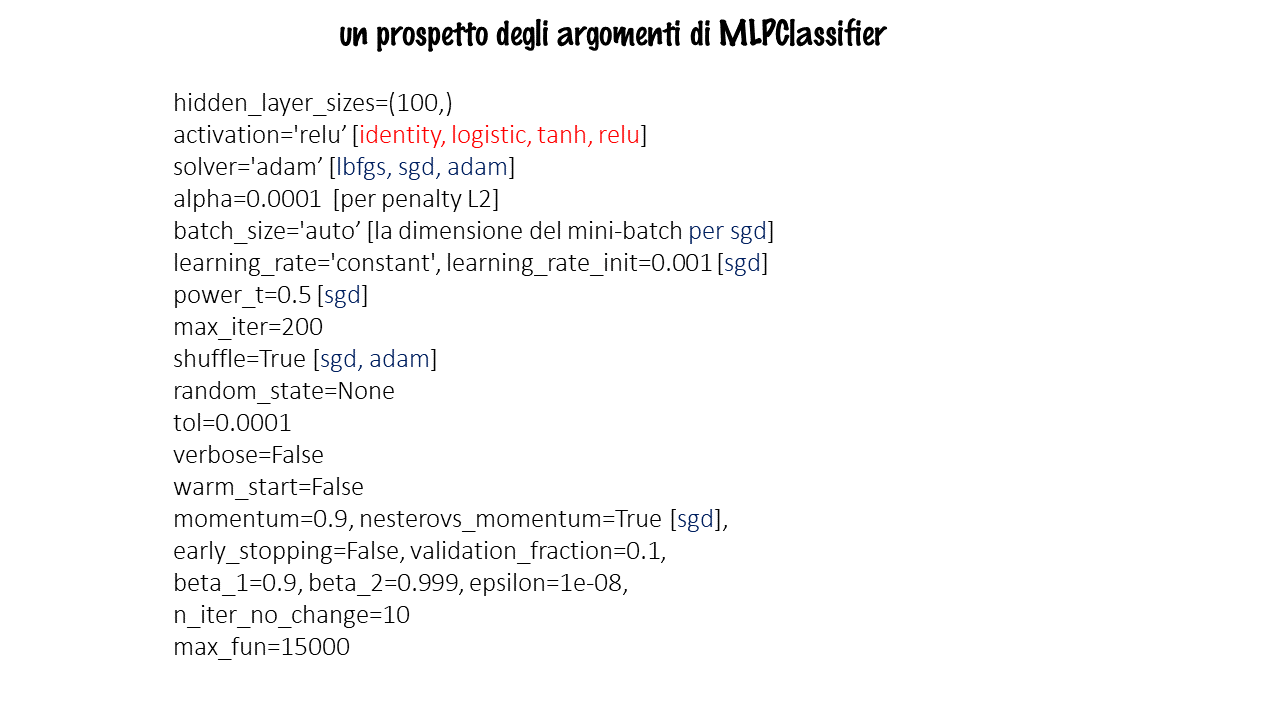

In [18]:
Image(filename='./images/MLPClassifier_argomenti.png', width=800) 

## ll calcolo della funzione logistica in Python
Per curiosità tecnica, calcoliamo queste tre attivazioni (viste nelle slide):

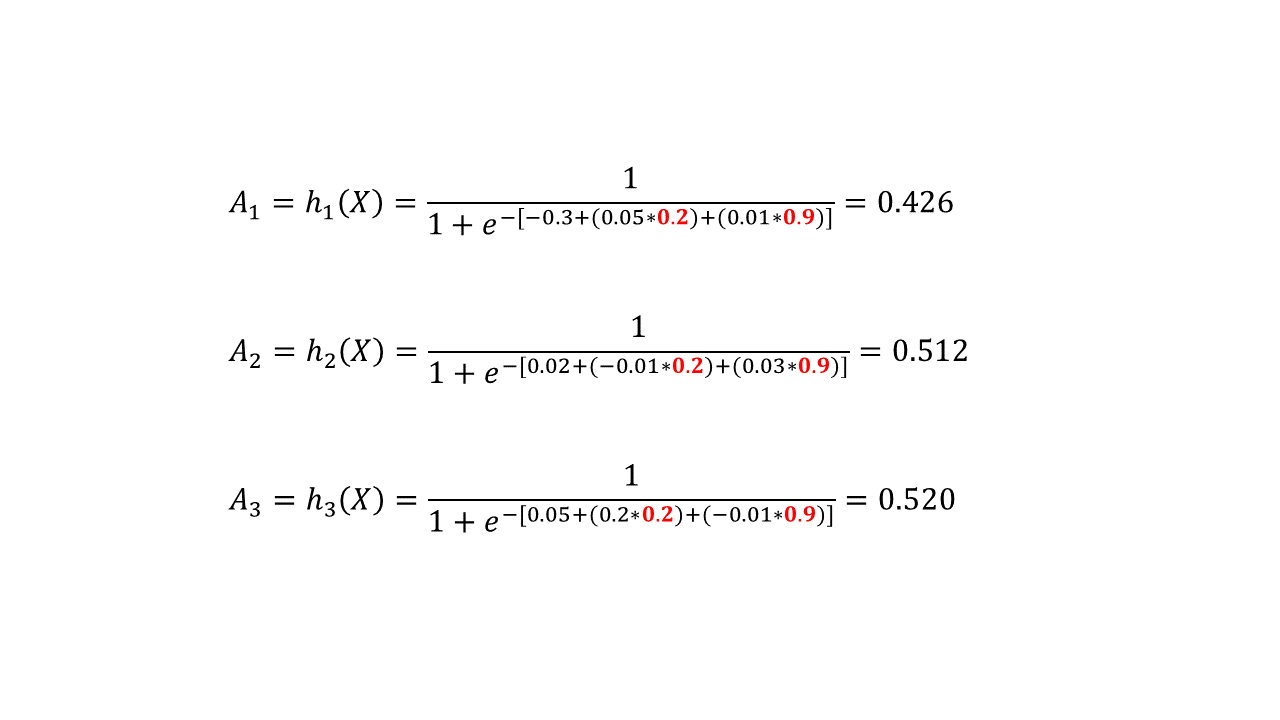

In [19]:
Image(filename='./images/NodiAk.png', width=800) 

In [41]:
import numpy as np

z1 = (-0.3+(0.05*0.2)+(0.01*0.9))            # il net input al primo nodo nascosto (k=1)
z2 = (0.02+(-0.01*0.2)+(0.03*0.9))           # il net input al primo nodo nascosto (k=2)
z3 = (0.05+(0.2*0.2)+(-0.01*0.9))            # il net input al primo nodo nascosto (k=3)

print('A1 = ',round(1/(1+np.exp(-z1)),4))    # A1 = g(z1)  - con g(z) = funzione logistica (sigmoidale): 1 / (1+e^-z)
print('A2 = ',round(1/(1+np.exp(-z2)),4))    # A2 = g(z2)  -    ""
print('A3 = ',round(1/(1+np.exp(-z3)),4))    # A3 = g(z3)  -    ""

A1 =  0.4302
A2 =  0.5112
A3 =  0.5202


## Esempio degli incidenti auto (di classificazione)
Dati ancora strutturati, come prima (e non ancora immagini od audio), ma REALI questa volta.<br>
E' un esempio utile per imparare poco per volta.<br><br>

Lo <u>storico</u> dei rapporti degli incidenti automobilistici può essere utile ad un ente/azienda del settore (<u>Vigili, 118, ACI, operatori dell'assistenza stradale, assicurazioni</u>, ecc) per prevedere rapidamente la **gravità** dell'incidente in base ai **primi riscontri**. In base infati ad alcuni primissimi dati, inclusi quelli GPS, questo modello può prevedere la gravità dell'incidente in tempo reale e così assegnare le **priorità** agli operatori di soccorso/intervento.<br>
La risposta di questo problema di <u>classificazione</u> è la gravità dell'incidente: **no-feriti, feriti, morti**.<br><br>
Esaminiamo innanzitutto i metadati del dataset (i significati delle colonne)

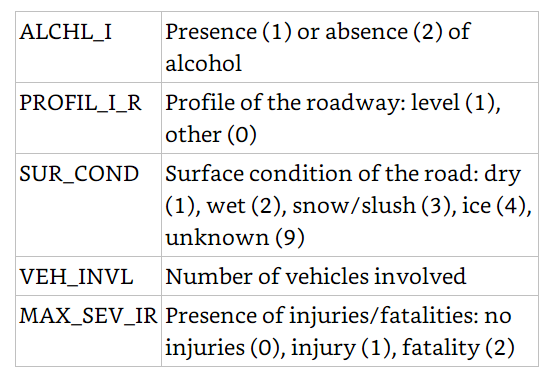

In [2]:
Image(filename='images/Dati_incidenti.png', width=400) 

In [3]:
# caricamento del dataset dal pacchetto dmba (non dalla directory locale!)
accidents_df = dmba.load_data('accidentsnn.csv')
accidents_df

,ALCHL_I,PROFIL_I_R,SUR_COND,VEH_INVL,MAX_SEV_IR
0,2,0,1,1,0
1,2,1,1,1,2
2,1,0,1,1,0
3,2,0,2,2,1
4,2,1,1,2,1
...,...,...,...,...,...
994,2,0,1,1,0
995,2,0,1,1,0
996,1,1,1,2,1
997,1,0,1,3,2


In [4]:
type(accidents_df)  # un dataframe pandas

pandas.core.frame.DataFrame

In [5]:
accidents_df.shape  # 999 incidenti

(999, 5)

In [6]:
accidents_df.dtypes # i data-type delle variabili ('dtype' sta proprio per 'data.type')

ALCHL_I       int64
PROFIL_I_R    int64
SUR_COND      int64
VEH_INVL      int64
MAX_SEV_IR    int64
dtype: object

In [7]:
# sono preliminarmente necessarie alcune trasformazioni.
# ALCHL_I e MAX_SEV_IR devono infatti essere trasformate in variabili categoriche (come un 'factor' di R).

accidents_df.SUR_COND = accidents_df.SUR_COND.astype('category')
accidents_df.MAX_SEV_IR = accidents_df.MAX_SEV_IR.astype('category')

# NB. Un'analoga trasformazione di ALCHL_I e di PROFIL_I_R non è necessaria perchè hanno solo due livelli.

Python ha i seguenti data-type **nativi**:<br>

* Text Type:	    *str*<br>
* Numeric Types:	*int*, *float*, *complex*<br>
* Sequence Types:	*list*, *tuple*, *range*<br>
* Mapping Type:	*dict*<br>
* Set Types:	    *set*, *frozenset*<br>
* Boolean Type:	*bool*<br>
* Binary Types:	*bytes*, *bytearray*, *memoryview*<br>
<br>

**Pandas** ha inoltre i seguenti data-type aggiuntivi:<br>
* stringhe alfanumeriche: *object* (data-type Python corrispondente: *str*)<br>
* interi: *int64* (data-type Python corrispondente: *int*)<br>
* reali: *float64* (data-type Python corrispondente: *float*)<br>
* ecc<br>
* **category** (data-type Python corrispondente: *NA*). E' un data-type di pandas per dati categorici. E' applicabile ad una *serie* oppure ad una *colonna* di un dataframe. Semplifica alcune operazioni. E' simile al *factor* di R. Più info [qui](https://pandas.pydata.org/pandas-docs/stable/user_guide/categorical.html#:~:text=Categoricals%20are%20a%20pandas%20data,or%20rating%20via%20Likert%20scales.)

In [8]:
accidents_df.dtypes # i nuovi data-type

ALCHL_I          int64
PROFIL_I_R       int64
SUR_COND      category
VEH_INVL         int64
MAX_SEV_IR    category
dtype: object

Esistono molto modi per vedere l'elenco delle categorie (di una colonna *category). Vedi [qui](https://stackoverflow.com/questions/52404971/get-a-list-of-categories-of-categorical-variable-python-pandas)

In [9]:
# vediamo alcuni di questi modi, per impratichirci un pò della ricchezza espressiva di python: 

col = accidents_df['SUR_COND']                       # una variabile di comodo per semplificare le righe seguenti.                          

print(col,'\n')                                      # anche i dati (le categorie a fine output)
print(pd.unique(col),'\n')                           # numero ed elenco delle categorie (ridondante)
print(list(set(list(col))),'\n')                     # solo l'elenco delle categorie
print(np.array(pd.Categorical(col).categories),'\n') # solo lelenco delle categorie, senza la virgola
print(col.value_counts(),'\n')                       # l'elenco delle categorie con la loro cardinalità
print(col.value_counts().count())                    # il numero totale di categorie

# NB. Tutti questi comandi erano eseguibili con successo, e con output molto simili, anche sul precedente formato numerico 
# di 'SUR_COND'. Ma NON la trasformazione in dummy variable, che andiamo a fare adesso e che richiede appunto il formato 
# 'category'.

0      1
1      1
2      1
3      2
4      1
      ..
994    1
995    1
996    1
997    1
998    1
Name: SUR_COND, Length: 999, dtype: category
Categories (5, int64): [1, 2, 3, 4, 9] 

[1, 2, 4, 3, 9]
Categories (5, int64): [1, 2, 3, 4, 9] 

[1, 2, 3, 4, 9] 

[1 2 3 4 9] 

1    782
2    177
4     28
3      8
9      4
Name: SUR_COND, dtype: int64 

5


In [10]:
# come sempre, per poter essere elaborate da un algoritmo di ML, le colonne di tipo 'category' della metrice X dei
# predittori devono essere prima convertite in variabili dummy (0,1);

# per la variabile 'SUR_COND' vogliamo creare K-1 categorie; escludiamo la categoria 9 (= unknown)
accidents_df_processed = pd.get_dummies(accidents_df, columns=['SUR_COND'])
accidents_df_processed = accidents_df_processed.drop(columns=['SUR_COND_9'])   
accidents_df_processed     # --> 4 variabili dummy, ora.
                           #     per comodità di visualizzazione sono messe in coda 

,ALCHL_I,PROFIL_I_R,VEH_INVL,MAX_SEV_IR,SUR_COND_1,SUR_COND_2,SUR_COND_3,SUR_COND_4
0,2,0,1,0,1,0,0,0
1,2,1,1,2,1,0,0,0
2,1,0,1,0,1,0,0,0
3,2,0,2,1,0,1,0,0
4,2,1,2,1,1,0,0,0
...,...,...,...,...,...,...,...,...
994,2,0,1,0,1,0,0,0
995,2,0,1,0,1,0,0,0
996,1,1,2,1,1,0,0,0
997,1,0,3,2,1,0,0,0


In [11]:
# le colonne del dataframe sono ora 8, a tutti gli effetti, come si evince anche da queste due funzioni:
print(accidents_df_processed.columns,'\n')
print(accidents_df_processed.dtypes)

Index(['ALCHL_I', 'PROFIL_I_R', 'VEH_INVL', 'MAX_SEV_IR', 'SUR_COND_1',
       'SUR_COND_2', 'SUR_COND_3', 'SUR_COND_4'],
      dtype='object') 

ALCHL_I          int64
PROFIL_I_R       int64
VEH_INVL         int64
MAX_SEV_IR    category
SUR_COND_1       uint8
SUR_COND_2       uint8
SUR_COND_3       uint8
SUR_COND_4       uint8
dtype: object


In [12]:
# i metadati (per pulizia espressiva):
outcome = 'MAX_SEV_IR'                                                   # la risposta
predictors = [c for c in accidents_df_processed.columns if c != outcome] # 7 predittori
print(outcome, '\n',predictors)

MAX_SEV_IR 
 ['ALCHL_I', 'PROFIL_I_R', 'VEH_INVL', 'SUR_COND_1', 'SUR_COND_2', 'SUR_COND_3', 'SUR_COND_4']


In [13]:
# usiamo la solita notazione del ML: la matrice X dei predittori ed il vettore y delle risposte: 
X = accidents_df_processed[predictors]
y = accidents_df_processed[outcome]
classes = sorted(y.unique())    # per plot successivi

# il partizionamento dei dati, con il solito metodo (già visto molte volte):
train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size=0.4, random_state=1)

In [14]:
# e finalmente il training della rete 7-2-3, con:
# - 7 nodi nel livello di input (per i 7 predittori);
# - 3 nodi nel livello di output (uno per ogni classe);
# - 1 livello nascosto fatto di 3 nodi che MPLClassifier implementa con 2 nodi:
# 
# NB. Il livello di input e di output sono configurati automaticamente dal costruttore MLPClassifier, in base
# appunto al numero di predittori e di classi, rispettivamente.
# Se la risposta è categorica (con m=numero delle classi) il numero di nodi del livello di output è sempre m-1 (cioè 
# MLPClassifier NON implementa lo schema one-hot encoding, che prevede m nodi di output).
# Se la risposta è numerica, il nodo di output è 1, a meno che il modello non sia a risposta multipla (caso non 
# esaminato in questo corso).
#
# Occorre invece configurare esplicitamente i livelli nascosti della rete (tramite l'argomento 
# 'hidden_layer_sizes').

clf = MLPClassifier(hidden_layer_sizes=(2,3), activation='logistic', solver='lbfgs', 
                                                    # gli argomenti già visti per l'esempio giocattolo; 
                                                    # ancora 'lbfgs' perchè il dataset è piccolo (1000 righe).
                    random_state=1)

# perchè 2 nodi nel livello nascosto? vedi più avanti la GridSearch.

In [15]:
clf.get_params()  # check dei valori degli argomenti di MLPClassifier().

{'activation': 'logistic',
 'alpha': 0.0001,
 'batch_size': 'auto',
 'beta_1': 0.9,
 'beta_2': 0.999,
 'early_stopping': False,
 'epsilon': 1e-08,
 'hidden_layer_sizes': 2,
 'learning_rate': 'constant',
 'learning_rate_init': 0.001,
 'max_fun': 15000,
 'max_iter': 200,
 'momentum': 0.9,
 'n_iter_no_change': 10,
 'nesterovs_momentum': True,
 'power_t': 0.5,
 'random_state': 1,
 'shuffle': True,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': False,
 'warm_start': False}

In [16]:
# da cosa si vede l'architettura della rete che sarà fittata, in particolare quanti sono i livelli/nodi nascosti?
# qui, dall'argomento 'hidden_layer_sizes'; più avanti, dalle dimensioni delle matrici dei parametri (forniti dal fit).

In [17]:
# i soliti tre passi di scikit-learn: dopo il costruttore, il fit (e, dopo, la predict):
clf.fit(train_X, train_y.values)

MLPClassifier(activation='logistic', hidden_layer_sizes=2, random_state=1,
              solver='lbfgs')

In [18]:
clf.intercepts_   # le 5 intercette (BIAS) del nostro modello 7-2-3; 
                  # - due per il livello nascosto, una per ogni net input (w10, w20);
                  # - le altre tre per il livello di output (3 nodi).

[array([-9.27167594e-04, -8.11780173e+00]),
 array([-21.47314424,  11.98419086,   9.97232137])]

In [19]:
clf.coefs_        # i pesi (WEIGHT) del nostro modello 7-2-3:
                  # - prima sono elencati i 14 (7x2) w-jk tra livello di input (7 nodi) e livello nascosto
                  #   (2 nodi), cioè: w11 e w21 come prima riga dell'array (relativa alle uscite di X1); poi 
                  #   w12 e w22 sulla seconda riga dell'array (relativa alle uscite di X2), e così via sino a X7;
                  # - poi sono elencati i 6 beta-km tra il livello nascosto e quello di output, e cioè;
                  #   beta-11,beta-12,beta-13,beta-21,beta-22,beta-23.

[array([[  0.12049569, -16.97492247],
        [ -3.76746665,  14.3997336 ],
        [ -0.19419502,   2.49470482],
        [  0.21873301, -23.72909889],
        [-19.53968696,  14.32969431],
        [-14.7950896 ,   0.84777134],
        [-26.33047839,   2.20448053]]),
 array([[ 58.00303176, -55.28215457,  -3.20255116],
        [  8.91209892,   7.83040898, -16.15600431]])]

In [20]:
# l'output più gradevole e comprensibile:
for i, (weights, intercepts) in enumerate(zip(clf.coefs_, clf.intercepts_)):
    print('Hidden layer' if i == 0 else 'Output layer', '{0[0]} => {0[1]}'.format(weights.shape))
    print(' Intercepts:\n ', intercepts)
    print(' Weights:')
    for weight in weights:
        print(' ', weight)
    print()

Hidden layer 7 => 2
 Intercepts:
  [-9.27167594e-04 -8.11780173e+00]
 Weights:
  [  0.12049569 -16.97492247]
  [-3.76746665 14.3997336 ]
  [-0.19419502  2.49470482]
  [  0.21873301 -23.72909889]
  [-19.53968696  14.32969431]
  [-14.7950896    0.84777134]
  [-26.33047839   2.20448053]

Output layer 2 => 3
 Intercepts:
  [-21.47314424  11.98419086   9.97232137]
 Weights:
  [ 58.00303176 -55.28215457  -3.20255116]
  [  8.91209892   7.83040898 -16.15600431]



Se si usa lo schema di codifica delle classi *one-hot encoding* (vedi le slide), si ha in output (la label prevista):
* 1-0-0: classe 0 (no injuries)
* 0-1-0: classe 1 (injuries)
* 0-0-1: classe 2 (fatality)

In [21]:
# ora la PSEUDO-previsione e l'accuratezza della classificazione (tramite la consueta matrice di confusione):
classificationSummary(train_y, clf.predict(train_X)) # funzione fornita dal package di utility 'dmba'.

                        # --> come si vede, la rete ha classificato quasi perfettamente le classi 0 (no feriti) 
                        #     ed 1 (feriti); ha invece commesso molti errori con la terza classe (morti), perchè ne ha
                        #     previsti correttamente solo 8/87 (< 10%).

Confusion Matrix (Accuracy 0.8664)

       Prediction
Actual   0   1   2
     0 331   0   1
     1   0 180   0
     2  30  49   8


In [22]:
# come si calcola manualmente l'accuratezza?
# servono alcune funzioni numpy:
# - np.sum           la somma di tutti gli elementi dell'array
# - array.trace()    la traccia dell'array, cioè la somma degli elementi della diagonale principale
# - la lunghezza dell'array? vedi so 187455
#   size = 1
#   for dim in np.shape(cm): size *= dim
#   size
from sklearn.metrics import confusion_matrix                # serve questa funzione di scikit-learn (anzichè quella del 
                                                            # package 'dmba')
cm = confusion_matrix(train_y, clf.predict(train_X))

cm.trace()/np.sum(cm)

0.8664440734557596

In [23]:
# lo stesso con i dati di test:
classificationSummary(valid_y, clf.predict(valid_X))

                        # --> come si vede, anche ora la rete ha classificato quasi perfettamente le classi 0  
                        #     ed 1; ha invece commesso anche ora molti errori con la terza classe (morti)

Confusion Matrix (Accuracy 0.8550)

       Prediction
Actual   0   1   2
     0 218   0   1
     1   0 119   0
     2  24  33   5


In [24]:
# e per finire le probabilità delle tre singole classi (per il dataset di test) con il consueto argomento 'predict_proba':

print(pd.concat([                                             # per la concatenazione di decisioni e probabilità
    pd.DataFrame(clf.predict(valid_X)),                       # le decisioni (la probabilità più alta)
    pd.DataFrame(clf.predict_proba(valid_X), columns=classes) # le probabilità singole (l'argomento 'columns' per l'header)
], axis=1))                                                   # 'axis=1' concatena per colonne ('axis=0' per righe)

     0             0             1         2
0    1  2.603670e-15  8.826762e-01  0.117324
1    0  5.582861e-01  6.486220e-12  0.441714
2    1  2.601065e-15  8.820377e-01  0.117962
3    1  2.601065e-15  8.820377e-01  0.117962
4    1  2.601065e-15  8.820377e-01  0.117962
..  ..           ...           ...       ...
395  1  3.106912e-14  6.795562e-01  0.320444
396  1  2.603670e-15  8.826762e-01  0.117324
397  0  9.601761e-01  4.758044e-14  0.039824
398  0  9.601761e-01  4.758044e-14  0.039824
399  0  9.601761e-01  4.758044e-14  0.039824

[400 rows x 4 columns]


**Nota sul numero dei parametri**:
* questo modello single-layer, come detto, è 7-2-3, cioè: j=7, k=2, m=3.
* i parametri sono *(j+1)k + (k+1)m* = 16+9=25.
* i modelli reali hanno 10^5-10^6-10^9 parametri!

### Grid search
Il numero ottimale di nodi del livello nascosto è individuabile tramite una [(parameter) grid search](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html).<br><br>
Si usa la Cross-Validation per fare **Model Selection** (e naturalmente anche *Model Assessment* in modo annidato) (vedi slide).<br><br>
Dall'help online di *GridSearchCV* di *scikit-learn*:
* GridSearchCV does an "exhaustive search over specified parameter values for an estimator";
* GridSearchCV "implements a *fit* and a *score* method. It also implements *predict*, *predict_proba*, *decision_function*, *transform* and *inverse_transform* if they are implemented in the estimator used;
* the parameters of the estimator used to apply these methods are optimized by **cross-validated grid-search** over <u>a parameter grid</u>.

In [25]:
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV

param_grid = {                                              # specifica dello stimatore 
    'hidden_layer_sizes': [(1), (2), (3), (4), (5)],        # la griglia (grid) di nodi (del livello nascosto) 
}
gridSearch = GridSearchCV(MLPClassifier(                    # lo stimatore usato prima
    
    activation='logistic', solver='lbfgs', random_state=1,  # per questi tre argomenti si usano gli stessi valori di prima;
    max_iter=1000),                                         # il numero max di iterazioni (epoche) è aumentato (il default 
                                                            # è 200) per permettere il massimo adattamento della rete  
                                                            # (anche a costo dell'overfitting)
                          
    # sino a qui gli argomenti dello stimatore, da qui in avanti gli argomenti della GridSearchCV                      
    
    param_grid,                  # la griglia di valori per l'iper-parametro (il numero di nodi del livello nascosto)
    cv=5,                        # il numero di fold per la cv, su ognuno dei quali è valutato lo "score di TEST",
                                 # che è una metrica di errore (quella dello stimatore; può anche essere custom)
    n_jobs=-1,                   # il numero di job da eseguire in parallelo; -1 significa tutti i processori. 
    
    return_train_score=True)     # "Computing training scores is used to get insights on how different parameter 
                                 # settings impact the overfitting/underfitting trade-off.
                                 # However, computing the scores on the training set can be computationally
                                 # expensive and is not strictly required to select the parameters that
                                 # yield the best generalization performance.

    # NB. Se il cursore è posizionato subito dopo GridSearchCV, shift+tab mostra la signature (gli argomenti)
    # di GridSearchCV; se il cursore è posizionato dopo MLPClassifier, shift+tab mostra la signature di
    # MLPClassifier.
                          
gridSearch.fit(train_X, train_y) # il fit
print('Best score: ', gridSearch.best_score_)        # lo score migliore tra i 5 modelli confrontati
print('Best parameters: ', gridSearch.best_params_)  # i parametri del modello migliore (salvati durante l'esecuzione)

Best score:  0.8647619047619047
Best parameters:  {'hidden_layer_sizes': 1}


In [26]:
# un altro output di 'gridSearch.fit' è lo score di test, per ognuno dei 5 modelli testati.
# NB. è uno score MEDIO perchè, come detto prima, per OGNI modello la funzione calcola diversi score (uno per ogni fold);
# per ogni modello è anche mostrata la dev. std degli score di test.
display=['param_hidden_layer_sizes', 'mean_test_score', 'std_test_score']
pd.DataFrame(gridSearch.cv_results_)[display]
                     # si sceglie il modello con media più alta; a parità di media scelgo il modello con devstd minore,
                     # tuttavia, nel caso di 2+ modelli che forniscano score molto simili e devstd differenti si può 
                     # scegliere il modello con la media leggermente inferiore ma con la devstd inferiore.
                     # ad esempio, nella seconda riga, se la devstd fosse 0.0001 potrei decidere di scegliere questo modello 

,param_hidden_layer_sizes,mean_test_score,std_test_score
0,1,0.864762,0.009892
1,2,0.864748,0.011403
2,3,0.863081,0.012749
3,4,0.859734,0.011501
4,5,0.853081,0.008611


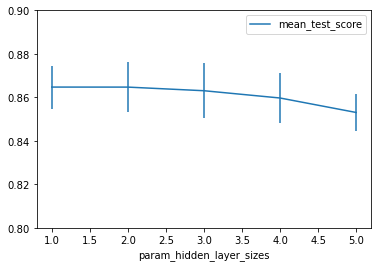

In [27]:
# le stesse informazioni, in forma di plot:
pd.DataFrame(gridSearch.cv_results_)[display].plot(x='param_hidden_layer_sizes', 
                                                   y='mean_test_score', yerr='std_test_score', ylim=(0.8, 0.9))
                                                   # NB. le etichette degli assi NON sono modificabili a piacere, perchè  
                                                   # sono i nomi di alcuni dei campi forniti da 'gridSearch.cv_results_'.

plt.show()

In [28]:
# proviamo allora a rieseguire costruzione, fit, predict e matrice di confusione con un solo nodo nel livello nascosto:
clf = MLPClassifier(hidden_layer_sizes=(1), activation='logistic', solver='lbfgs', random_state=1)
clf.fit(train_X, train_y.values)
classificationSummary(valid_y, clf.predict(valid_X))
                      # --> non c'è miglioramento di accuratezza, perchè, nel plot precedente, le medie e le dev.std degli   
                      #     score di test dei modelli con 1 oppure 2 nodi sono praticamente le medesime. 

Confusion Matrix (Accuracy 0.8550)

       Prediction
Actual   0   1   2
     0 218   0   1
     1   0 119   0
     2  24  33   5


<u>NOTE sul numero di livelli / nodi nascosti di una rete MLP</u> [da PML, pp. 491-493; ISLRv2, p. 407; DMfBA python, p. 295, pp. 288-289, p. 298]:
* 1 oppure 2 nodi per il livello nascosto è, in questo esempio, il  miglior **equilibrio** tra una rete inutilmente complessa (*overfitting*) ed un bias (distorsione) troppo alto (*underfitting*). Si cerca cioè, come sempre nel ML/DL, di migliorare l'accuratezza predittiva sul training set senza deteriorare l'accuratezza predittiva sul test set (la *generalizzazione* che ci interessa);<br><br>
* da prove empiriche risulta che, in questo esempio, l'aggiunta di altri livelli nascosti (cioè, **2+**) alla rete produce **complessità inutile** che non migliora significativamente l'accuratezza predittiva sul test set;<br><br>
* definizione: la **capacity** di una rete è la sua capacità di approssimare funzioni più o meno complesse (cioè, nel caso della classificazione, di Decision Boundary), e dipende dal numero di livelli nascosti e di nodi di questi livelli;<br><br>
* in generale, a prescindere da questo esempio, una  rete neurale *feed-forward* con un <u>singolo livello nascosto con un grande numero di nodi</u> ha, in teoria, la capacità di approssimare (fittare) bene la maggior parte delle (tutte?) le funzioni (continue) **f(X.vett)**, sia nella regressione che nella classificazione; lo stabilisce infatti il [teorema dell'approssimazione universale](https://en.wikipedia.org/wiki/Universal_approximation_theorem);<br><br>
* in pratica, tuttavia, è **molto più facile (computazionalmente) fittare una rete con molti livelli nascosti, ognuno con pochi nodi**;<br><br>
* l'aggiunta di livelli nascosti, infatti, anzichè di nodi nascosti all'unico livello nascosto, rende la rete *più profonda* (*deeper* anzichè *wider*); una rete deep raggiunge la stessa capacity di una wide con meno parametri (il pro, da cui il vantaggio computazionale), ma è più esposta al rischio della [scomparsa del gradiente](https://it.wikipedia.org/wiki/Problema_della_scomparsa_del_gradiente) (il contro); <br><br>
* inoltre una rete con molti parametri, come tutti i modelli di ML/DL, oltre ad essere più difficile da fittare, è maggiormente esposta al rischio di overfitting;<br><br>
* in concreto, il consiglio è sempre di configurare inizialmente la rete con **1 livello nascosto**, <u>esplorando</u> il numero ottimale dei suoi nodi con la *GridSearch*, come si è fatto proprio in questo esempio; e poi eventualmente provare ad aumentare il numero di livelli nascosti, cercando la profondità e non l'ampiezza;<br><br>
* una regola pratica (*rule of thumb*) a volte usata è: iniziare con 1 livello nascosto con *p* nodi (p = numero di predittori / feature) e poi gradualmente aumentare o diminuire il numero dei nodi in base all'andamento dell'accuratezza predittiva;<br><br>
* ciò detto, le grandi reti neurali moderne sono sia deep che wide;<br><br>
* un punto di attenzione, infine, molto importante: la capacità di fittare funzioni **non-lineari** NON dipende dal numero di livelli / nodi nascosti, ma dalla funzione di attivazione che si usa! [Una rete senza livelli nascosti (come il percettrone e l'adaline), comunque, non è in grado di fittare funzioni non-lineari f(X.vett); ed infatti, con le opportune funzioni di attivazione g, essa si riduce alla regressione lineare o logistica!]. Se una rete non è in grado di fittare efficacemente una certa funzione, sia l'accuratezza predittiva del training set che quella del test set sono basse (l'overfitting, al contrario, determina un'alta accuratezza predittiva sui dati di training e bassa sui dati di test). 

### Prove con il livello nascosto

In [29]:
clf = MLPClassifier(hidden_layer_sizes=(2,2), # the i-th element represents the number of neurons in the i-th hidden layer
                    activation='logistic', solver='lbfgs', 
                    random_state=1)
clf.fit(train_X, train_y.values)
classificationSummary(valid_y, clf.predict(valid_X))
                                              # --> leggero miglioramento!

Confusion Matrix (Accuracy 0.8675)

       Prediction
Actual   0   1   2
     0 218   0   1
     1   0 116   3
     2  24  25  13


In [31]:
clf = MLPClassifier(hidden_layer_sizes=(2,2,2), # the i-th element represents the number of neurons in the i-th hidden layer
                    activation='logistic', solver='lbfgs', 
                    random_state=1, max_iter=1000)
clf.fit(train_X, train_y.values)
classificationSummary(valid_y, clf.predict(valid_X))
                                              # --> invariato

Confusion Matrix (Accuracy 0.8500)

       Prediction
Actual   0   1   2
     0 218   1   0
     1   0 116   3
     2  24  32   6


In [32]:
clf = MLPClassifier(hidden_layer_sizes=(2,2,2,2), # the i-th element represents the number of neurons in the i-th hidden layer
                    activation='logistic', solver='lbfgs', 
                    random_state=1, max_iter=1000)
clf.fit(train_X, train_y.values)
classificationSummary(valid_y, clf.predict(valid_X))
                                              # --> grande peggioramento, come si evince anche chiaramemte dalla matrice
                                              #     di confusione

Confusion Matrix (Accuracy 0.5475)

       Prediction
Actual   0   1   2
     0 219   0   0
     1 119   0   0
     2  62   0   0


In [33]:
clf = MLPClassifier(hidden_layer_sizes=(10,10,10,10), # the i-th element represents the number of neurons in the i-th hidden layer
                    activation='logistic', solver='lbfgs', 
                    random_state=1, max_iter=1000)
clf.fit(train_X, train_y.values)
classificationSummary(valid_y, clf.predict(valid_X))
                                              # --> un pò meglio

Confusion Matrix (Accuracy 0.8700)

       Prediction
Actual   0   1   2
     0 218   0   1
     1   0 113   6
     2  24  21  17


In [34]:
clf = MLPClassifier(hidden_layer_sizes=(100,10,10,10), # the i-th element represents the number of neurons in the i-th hidden layer
                    activation='logistic', solver='lbfgs', 
                    random_state=1, max_iter=1000)
clf.fit(train_X, train_y.values)
classificationSummary(valid_y, clf.predict(valid_X))
                                              # --> molto peggio

Confusion Matrix (Accuracy 0.5475)

       Prediction
Actual   0   1   2
     0 219   0   0
     1 119   0   0
     2  62   0   0


In [35]:
# per curiosità vediamo l'accuratezza di questo modello sui dati di training:
classificationSummary(train_y, clf.predict(train_X))
                           # non è un problema di overfitting ma di fitting

Confusion Matrix (Accuracy 0.5543)

       Prediction
Actual   0   1   2
     0 332   0   0
     1 180   0   0
     2  87   0   0


In [36]:
clf = MLPClassifier(hidden_layer_sizes=(2), # the i-th element represents the number of neurons in the i-th hidden layer
                    activation='logistic', solver='sgd', 
                    random_state=1, max_iter=1000)
clf.fit(train_X, train_y.values)
classificationSummary(valid_y, clf.predict(valid_X))
                                              # --> molto peggio (come noto con piccoli dataset)

Confusion Matrix (Accuracy 0.5475)

       Prediction
Actual   0   1   2
     0 219   0   0
     1 119   0   0
     2  62   0   0


In [37]:
clf = MLPClassifier(hidden_layer_sizes=(2), # the i-th element represents the number of neurons in the i-th hidden layer
                    activation='logistic', solver='adam', 
                    random_state=1, max_iter=2000)
clf.fit(train_X, train_y.values)
classificationSummary(valid_y, clf.predict(valid_X))
                                              # --> con 1000 iterazioni non converge
                                              # --> con 2000 iterazioni, è quasi uguale a 'lbfgs'

Confusion Matrix (Accuracy 0.8450)

       Prediction
Actual   0   1   2
     0 218   0   1
     1   0 119   0
     2  27  34   1


### Cross-Validation con *MLPClassifier* 
Vedi [qui](https://datascience.stackexchange.com/questions/19768/how-to-implement-pythons-mlpclassifier-with-gridsearchcv).

In [54]:
# 620 secondi con processore 4GHZ e 16 GB RAM
import time
start_time = time.time()

RANDOM_SEED = 1
GRID = [
    {'scaler': [StandardScaler()],
     'estimator': [MLPClassifier(random_state=RANDOM_SEED)],
     'estimator__solver': ['adam'],
     'estimator__learning_rate_init': [0.0001],
     'estimator__max_iter': [300],
     'estimator__hidden_layer_sizes': [(500, 400, 300, 200, 100), (400, 400, 400, 400, 400), (300, 300, 300, 300, 300), (200, 200, 200, 200, 200)],
     'estimator__activation': ['logistic', 'tanh', 'relu'],
     'estimator__alpha': [0.0001, 0.001, 0.005],
     'estimator__early_stopping': [True, False]
     }
]

# 72 possibili combinazioni(4 sizes x 3 activation x 3 alpha x 2 early_stopping)
PIPELINE = Pipeline([('scaler', None), ('estimator', MLPClassifier())])
CV_SPLIT = 5

grid_search = GridSearchCV(estimator=PIPELINE, param_grid=GRID, 
                            scoring=make_scorer(accuracy_score),# average='macro'), 
                            n_jobs=-1, cv=CV_SPLIT, refit=True, verbose=1, 
                            return_train_score=False)

grid_search.fit(X, y)

print("--- %s seconds ---" % (time.time() - start_time))

Fitting 5 folds for each of 72 candidates, totalling 360 fits
--- 620.7370181083679 seconds ---


In [35]:
grid_search.cv_results_

NameError: name 'grid_search' is not defined

In [58]:
grid_search.best_estimator_

Pipeline(steps=[('scaler', StandardScaler()),
                ('estimator',
                 MLPClassifier(activation='tanh', early_stopping=True,
                               hidden_layer_sizes=(300, 300, 300, 300, 300),
                               learning_rate_init=0.0001, max_iter=300,
                               random_state=1))])

In [59]:
grid_search.best_score_

0.8658743718592966

In [60]:
grid_search.best_params_

{'estimator': MLPClassifier(activation='tanh', early_stopping=True,
               hidden_layer_sizes=(300, 300, 300, 300, 300),
               learning_rate_init=0.0001, max_iter=300, random_state=1),
 'estimator__activation': 'tanh',
 'estimator__alpha': 0.0001,
 'estimator__early_stopping': True,
 'estimator__hidden_layer_sizes': (300, 300, 300, 300, 300),
 'estimator__learning_rate_init': 0.0001,
 'estimator__max_iter': 300,
 'estimator__solver': 'adam',
 'scaler': StandardScaler()}

Vedi anche [questo notebook](https://github.com/angeloruggieridj/MLPClassifier-with-GridSearchCV-Iris/blob/master/iris.ipynb).

### Fit delle probabilità di classe separate (3 risposte)
(dal nb ch. 11 di DMBA python).<br>

In [44]:
accidents_df = dmba.load_data('accidentsnn.csv')
accidents_df.SUR_COND = accidents_df.SUR_COND.astype('category')
accidents_df.MAX_SEV_IR = accidents_df.MAX_SEV_IR.astype('category')
processed = pd.get_dummies(accidents_df)
processed = processed.drop(columns=['SUR_COND_9'])

# ecco le tre risposte separate:
outcome = ['MAX_SEV_IR_0', 'MAX_SEV_IR_1', 'MAX_SEV_IR_2']
predictors = [c for c in processed.columns if c not in outcome]
classes = sorted(outcome)

X = processed[predictors]
y = processed[outcome]
train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size=0.4, random_state=1)
clf = MLPClassifier(hidden_layer_sizes=(2), activation='logistic', solver='lbfgs',
                    random_state=1, max_iter=500)
clf.fit(train_X, train_y)

# training performance (usa 'idxmax' per rovesciare il one-hot-encoding)
trainPrediction = pd.DataFrame(clf.predict(train_X), columns=outcome).idxmax(axis=1)
classificationSummary(train_y.idxmax(axis=1), trainPrediction, class_names=classes)

print()

# validation performance (usa 'idxmax' per rovesciare il one-hot-encoding)
validPrediction = pd.DataFrame(clf.predict(valid_X), columns=outcome).idxmax(axis=1)
classificationSummary(valid_y.idxmax(axis=1), validPrediction, class_names=classes)

Confusion Matrix (Accuracy 0.8731)

             Prediction
      Actual MAX_SEV_IR_0 MAX_SEV_IR_1 MAX_SEV_IR_2
MAX_SEV_IR_0          332            0            0
MAX_SEV_IR_1            0          170           10
MAX_SEV_IR_2           31           35           21

Confusion Matrix (Accuracy 0.8675)

             Prediction
      Actual MAX_SEV_IR_0 MAX_SEV_IR_1 MAX_SEV_IR_2
MAX_SEV_IR_0          218            0            1
MAX_SEV_IR_1            0          113            6
MAX_SEV_IR_2           24           22           16


### Evitare l'overfitting

## ML o DL?
Vedi ISLR v2, pp. 432-433 e 443-445.

## Esempio grande
Classificazione con grande dataset, solver='sgd' e learning rate secondo le rule of thumb di DMfBA python, p. 298.

## Esempio giocattolo (di regressione)
Con il metodo `MLPRegressor` di *scikit-learn*, l'analogo di `MLPClassifier` per la regressione.
Usiamo come dataset Boston Housing che riguarda il prezzo delle case nei dintorni di Boston (anni 1970 circa).

In [45]:
from sklearn.neural_network import MLPRegressor
import numpy as np
import matplotlib.pyplot as plt
from sklearn import neural_network
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, explained_variance_score

In [46]:
boston = datasets.load_boston()
X = boston.data                  # i predittori
y = boston.target                # le risposte
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)

Metodo: MLP con ReLU
RMSE ottenuto: 3.6310


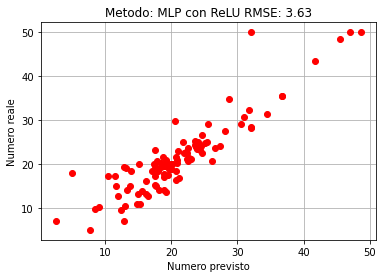

Metodo: MLP con Logistic Neurons
RMSE ottenuto: 4.6243


C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


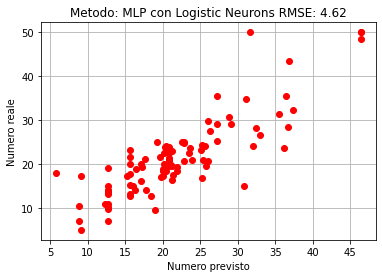

Metodo: MLP con TanH Neurons
RMSE ottenuto: 4.5945


C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


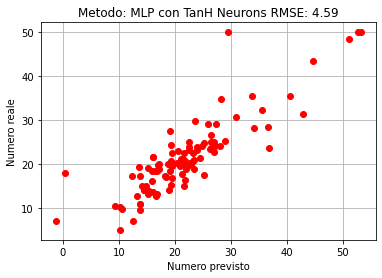

In [47]:
# la costruzione ed il confronto di 3 modelli di regressione NN con differenti funzioni di attivazione e solver
n_fig = 0
for name,nn_unit in [
    ('MLP con ReLU', neural_network.MLPRegressor(activation='relu',solver='lbfgs',max_iter=10000)),
    ('MLP con Logistic Neurons', neural_network.MLPRegressor(activation='logistic',solver='lbfgs',max_iter=10000)),
    ('MLP con TanH Neurons', neural_network.MLPRegressor(activation='tanh',solver='lbfgs',max_iter=100000)),
]:
    modello = nn_unit.fit(X_train,y_train)
    yp = nn_unit.predict(X_test)                  # le previsioni
    rmse = np.sqrt(mean_squared_error(y_test,yp)) # il rooted MSE
    print('Metodo: %s' %name)
    print('RMSE ottenuto: %.4f' %rmse)
    n_fig = n_fig + 1
    plt.figure(n_fig)
    plt.plot(yp,y_test,'ro')
    plt.xlabel('Numero previsto')
    plt.title('Metodo: %s RMSE: %.2f' %(name,rmse))
    plt.ylabel('Numero reale')
    plt.grid(True)
    plt.show()
    
                       # --> Vince il modello con il valore a sx (nel plot) più basso.

[Qui](https://scikit-learn.org/stable/auto_examples/neural_networks/plot_mlp_training_curves.html) c'è il codice per le curve delle loss function per alcune impostazioni del modello, per confrontare le prestazioni predittive e scegliere la combinazione migliore.

In [67]:
modello.coefs_

[array([[ 1.02747463e-01, -1.14201148e+00, -1.65433894e-01, ...,
         -1.01651939e-01, -1.02977394e-01, -3.39433730e-03],
        [-7.61371573e-02,  2.35646574e-01, -2.27711464e-02, ...,
          8.73863944e-02, -1.22391419e-01, -1.62802931e-01],
        [ 2.09064949e-01,  3.94588532e-01, -2.17706736e-01, ...,
         -1.18558537e-01,  1.99900203e-02,  1.79027107e-01],
        ...,
        [-1.70074800e-01, -1.06136237e-01,  1.20187073e-04, ...,
         -1.75990893e-02,  5.06718373e-02,  1.26764241e-01],
        [ 1.91261705e-01,  5.27270915e-01,  4.97226675e-02, ...,
          2.93656014e-01,  1.30886933e-01, -1.41721270e-02],
        [ 2.51160735e-02, -2.33632438e+00, -1.62498286e-01, ...,
          2.37494713e-01, -8.49409490e-02, -1.15875415e-01]]),
 array([[ 2.19490529e-01],
        [ 1.38828931e+00],
        [ 5.09640844e-01],
        [ 5.18036654e-01],
        [ 2.44458820e-01],
        [-5.25756302e-01],
        [-5.64504114e-01],
        [-4.36118903e-01],
        [ 2.8

## to-do list
* drop-out: prove e teoria
* transfer learning (classificatore pre-allenato): come usare ImageNet
* data augmentation: prove
* il gradiente vanishing (anche teoria)
* la doppia discesa del gradiente (anche teoria)